# Spatial Stochastic Simulation with SpatialPy

## Definition of the model

Here we illustrate how to implement the model describet in [Sturrock M, Hellander A, Matzavinos A, Chaplain MAJ. 2013 Spatial stochastic modelling of the Hes1 gene regulatory network: intrinsic noise can explain heterogeneity in embryonic stem cell differentiation. J R Soc Interface 10:20120988]

You may need to install specific version to get this notebook to work:

python3 -m pip install meshio==2.3.10

python3 -m pip install pygmsh==5.0.2

### Imports and definitions

In [1]:
%matplotlib inline

import os
import sys
sys.path.insert(1, "../..")
import numpy
import matplotlib.pyplot as plt

import spatialpy

In [2]:
class Nucleus(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 + x[2]**2 <= 3**2

In [3]:
class Cytoplasm(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return x[0]**2 + x[1]**2 + x[2]**2 > 3**2

### Model

In [4]:
def read_stochss_subdomain_file(cls, filename):
    """
    Read a StochSS Domain (.domn) file or
    pull a StochSS Domain from a StochSS Spatial Model (.smdl) file
    """
    with open(filename,'r') as fd:
        for ln,line in enumerate(fd):
            #print(line.rstrip())
            try:
                (ndx,type_id) = line.rstrip().split(',')
                dom.type[int(ndx)] = int(type_id)
                print(f"{ln} dom.type[{ndx}]={type_id}")
            except ValueError as e:
                print(e)
                print(line)
                raise e
    


In [5]:
dom = spatialpy.Domain.read_msh_file("mesh/cell.msh")

In [6]:
dom.coordinates().shape

(11019, 3)

In [7]:
dom.type

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
read_stochss_subdomain_file(dom,"mesh/GRN_Spatial.subdomains.txt")

0 dom.type[0]=2
1 dom.type[1]=2
2 dom.type[2]=2
3 dom.type[3]=2
4 dom.type[4]=2
5 dom.type[5]=2
6 dom.type[6]=2
7 dom.type[7]=2
8 dom.type[8]=2
9 dom.type[9]=2
10 dom.type[10]=2
11 dom.type[11]=2
12 dom.type[12]=2
13 dom.type[13]=2
14 dom.type[14]=2
15 dom.type[15]=2
16 dom.type[16]=2
17 dom.type[17]=2
18 dom.type[18]=2
19 dom.type[19]=2
20 dom.type[20]=2
21 dom.type[21]=2
22 dom.type[22]=2
23 dom.type[23]=2
24 dom.type[24]=2
25 dom.type[25]=2
26 dom.type[26]=2
27 dom.type[27]=2
28 dom.type[28]=2
29 dom.type[29]=2
30 dom.type[30]=2
31 dom.type[31]=2
32 dom.type[32]=2
33 dom.type[33]=2
34 dom.type[34]=2
35 dom.type[35]=2
36 dom.type[36]=2
37 dom.type[37]=2
38 dom.type[38]=2
39 dom.type[39]=2
40 dom.type[40]=2
41 dom.type[41]=2
42 dom.type[42]=2
43 dom.type[43]=2
44 dom.type[44]=2
45 dom.type[45]=2
46 dom.type[46]=2
47 dom.type[47]=2
48 dom.type[48]=2
49 dom.type[49]=2
50 dom.type[50]=2
51 dom.type[51]=2
52 dom.type[52]=2
53 dom.type[53]=2
54 dom.type[54]=2
55 dom.type[55]=2
56 dom.type[

In [20]:
class hes1(spatialpy.Model):
    def __init__(self, model_name="hes1"):
        spatialpy.Model.__init__(self, model_name)

        #Domain
        #domain = spatialpy.Domain.read_msh_file("mesh/cell.msh")
        domain = spatialpy.Domain.read_xml_mesh("mesh/GRN_Spatial.mesh.xml")
        
        domain.read_stochss_subdomain_file("mesh/GRN_Spatial.subdomains.txt")
        self.set_domain(domain)
        #Types
        cytoplasm=1
        #self.set_type(Cytoplasm(), cytoplasm)
        #self.set_type(Nucleus(), 2)
        # promoter site
        #self.domain.type[self.domain.closest_vertex([0]*3)] = 3

        #Parameters
        mu = 2e-3
        kappa=0.015
        ka = 1e7
        kd = 0.01
        gamma_m = 6e-4 
        gamma_p = gamma_m/2.0 
        NA = 6.022e23
        D_P=1e-12
        D_mRNA=1e-12
        
        mu = spatialpy.Parameter(name='mu', expression=mu)
        kappa = spatialpy.Parameter(name='kappa', expression=kappa)
        ka = spatialpy.Parameter(name='ka', expression=ka/(1000*NA))
        kd = spatialpy.Parameter(name='kd', expression=kd)
        gamma_m = spatialpy.Parameter(name='gamma_m', expression=gamma_m)
        gamma_p = spatialpy.Parameter(name='gamma_p', expression=gamma_p)
        self.add_parameter([mu,kappa,ka,kd,gamma_m,gamma_p])

        # Species
        G_f = spatialpy.Species(name='G_f', diffusion_constant=0.0)
        G_o = spatialpy.Species(name='G_o', diffusion_constant=0.0)
        mRNA = spatialpy.Species(name='mRNA',diffusion_constant=D_mRNA)
        P = spatialpy.Species(name='P', diffusion_constant=D_P)
        self.add_species([G_f,G_o,mRNA,P])

         # Reactions
        rxn1 = spatialpy.Reaction(name = 'R1',reactants={G_f:1,P:1}, products = {G_o:1}, rate=ka)
        rxn2 = spatialpy.Reaction(name = 'R2',reactants={mRNA:1}, products = {mRNA:1,P:1}, rate=kappa,restrict_to=cytoplasm)
        rxn3 = spatialpy.Reaction(name = 'R3',reactants={G_f:1}, products = {G_f:1,mRNA:1},rate=mu)
        rxn4 = spatialpy.Reaction(name = 'R4',reactants={mRNA:1}, products = {}, rate=gamma_m)
        rxn5 = spatialpy.Reaction(name = 'R5',reactants={P:1}, products = {}, rate=gamma_p)
        rxn6 = spatialpy.Reaction(name = 'R6',reactants={G_o:1}, products = {G_f:1,P:1}, rate=kd)

        self.add_reaction([rxn1,rxn2,rxn3,rxn4,rxn5,rxn6])
        
        #Initail Conditions
        self.add_initial_condition(spatialpy.PlaceInitialCondition(G_f, 1, location=[0,0,0]))
        
        self.timespan(numpy.linspace(0,24*3600,2000) , timestep_size=1)

In [21]:
model = hes1()

## Running the model and processing the results

In [23]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 611 ms, sys: 0 ns, total: 611 ms
Wall time: 3.6 s
/tmp/spatialpy_build_nqk01w_7


In [24]:
#%time result = model.run(debug_level=0)
%time result = sol.run()

CPU times: user 62.5 ms, sys: 9.52 ms, total: 72 ms
Wall time: 32min 26s


### Plot the evolution of the copy number of a given species

In [40]:
def plot_hes1(result):
    protein = result.get_species("P")
    proteinsum = numpy.sum(protein,axis=1)
    plt.plot(result.tspan,proteinsum,'r', label='protein')
    mRNA = result.get_species("mRNA")
    mRNAsum=numpy.sum(mRNA[:],axis=1)
    plt.plot(result.tspan,mRNAsum,'b', label='mRNA')
    plt.legend(loc='best')

CPU times: user 35.8 s, sys: 406 ms, total: 36.2 s
Wall time: 36.2 s


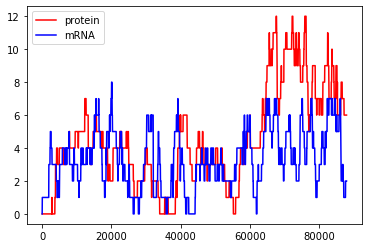

In [41]:
%time plot_hes1(result)

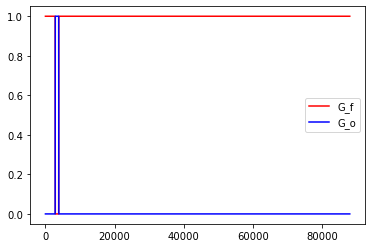

In [42]:
pf = numpy.sum(result.get_species("G_f"),axis=1)
po = numpy.sum(result.get_species("G_o"),axis=1)
plt.plot(result.tspan,pf,'r',label="G_f")
plt.plot(result.tspan,po,'b',label="G_o")
plt.legend(loc="best")

# Replicating issue 169
https://github.com/StochSS/SpatialPy/issues/169

In [44]:
model.tspan.shape

(87956,)

In [45]:
result.tspan.shape

(2000,)